# FER

In [1]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
n_classes = 7
classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))

img_size = 48
# batch_size = 1024
batch_size = 64

current_model = 'fer2013'
# final_model_path = current_model + '.h5'

In [3]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

C:\Users\Asus\anaconda3\envs\TensorFlow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


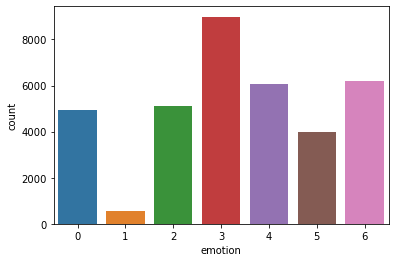

In [5]:
sns.countplot(df.emotion)
pyplot.show()

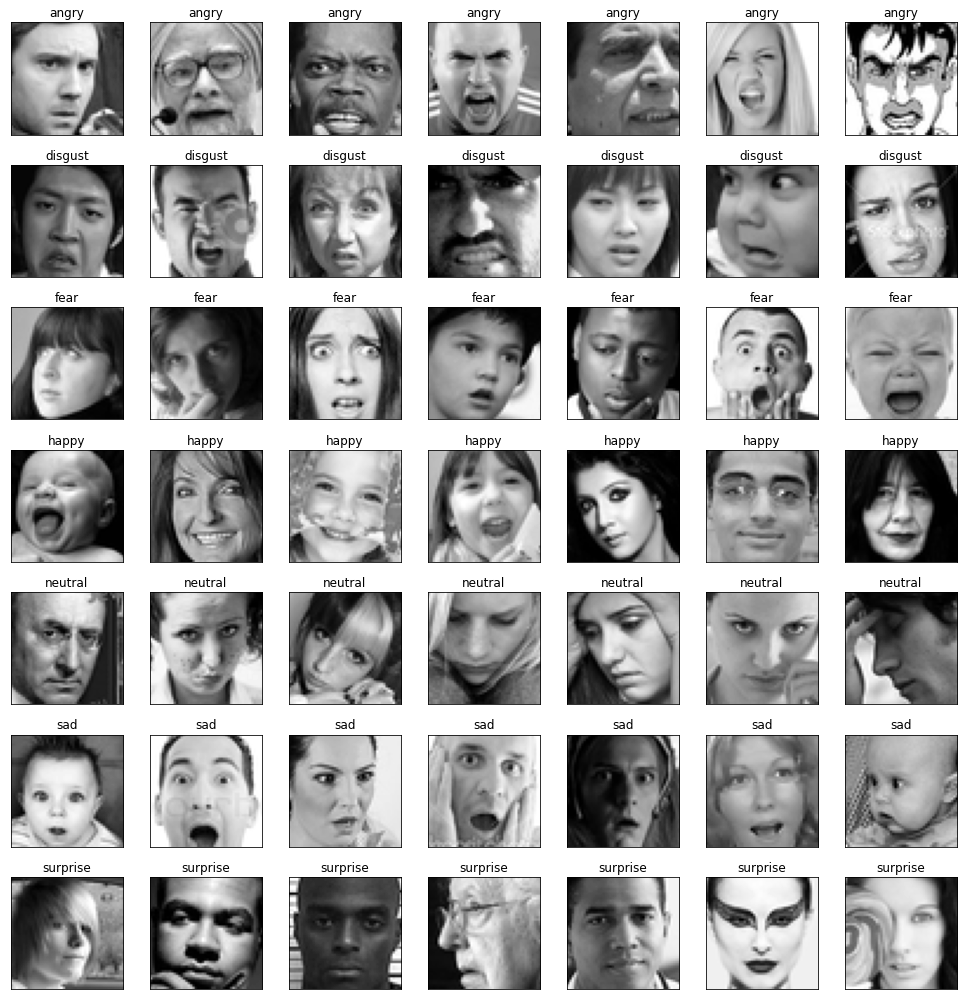

In [6]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(classes[label])
        pyplot.tight_layout()

In [7]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()

In [8]:
def int2emo(num):
    if num == 0:
        return 'Angry'
    elif num == 1:
        return 'Disgust'
    elif num == 2:
        return 'Fear'
    elif num == 3:
        return 'Happy'
    elif num == 4:
        return 'Neutral'
    elif num == 5:
        return 'Sad'
    else:
        return 'Surprise'

## Loading the data

In the following cell, we load the test data for a pretrained model from an ``.npy`` file. This is the data that we will use our model on, to predict the emotions and plot the confusion matrix.

In [9]:
test_data_x = np.load(current_model + '_test_data_x.npy')
test_data_y_one_hot = np.load(current_model + '_test_data_y_one_hot.npy')
n_test_ins = test_data_x.shape[0]
n_test_ins

3589

### Loading the model

The model is an ensemble duonet, which means that it is an aggregation of a lot of smaller Neural Networks, combined into one big Neural Network. 

In [10]:
BEST_WEIGHT_FILE = './' + current_model + '.hdf5'

print('> loading trained model from ' + BEST_WEIGHT_FILE + '...', end='')
model = load_model(BEST_WEIGHT_FILE)
print('done.')

> loading trained model from ./fer2013.hdf5...done.


In [11]:
model.summary()

Model: "ensemble_duonet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv_1_1_net_1 (Conv2D)         (None, 48, 48, 64)   640         input[0][0]                      
__________________________________________________________________________________________________
conv_1_1_net_2 (Conv2D)         (None, 48, 48, 64)   640         input[0][0]                      
__________________________________________________________________________________________________
conv_1_1_net_3 (Conv2D)         (None, 48, 48, 64)   640         input[0][0]                      
____________________________________________________________________________________

In [12]:
test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(test_data_x)
test_generator = test_datagen.flow(test_data_x, test_data_y_one_hot, batch_size=batch_size, shuffle=False)

y_pred_ = model.predict_generator(generator=test_generator, steps=n_test_ins/batch_size, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
57/56 [==============================] - 47s 832ms/step


### Confusion Matrix

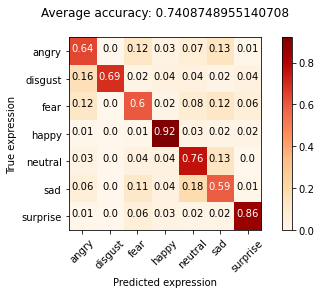

In [13]:
# Predictions
y_pred = np.argmax(y_pred_, axis=1)
# Ground truth
t_te = np.argmax(test_generator.y, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.OrRd,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [14]:
rnd_indx = np.random.randint(0, test_data_x.shape[0])
test_img = test_data_x[rnd_indx, :, :]
test_img = test_img.reshape((1, test_img.shape[0], test_img.shape[1], test_img.shape[2]))

In [15]:
pred_emo = int2emo(y_pred[rnd_indx])
true_emo = int2emo(t_te[rnd_indx])

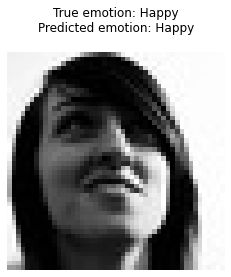

In [16]:
plt.imshow(test_img[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('True emotion: ' + true_emo + '\nPredicted emotion: ' + pred_emo + '\n')
plt.show()

In [17]:
model.save("model2.h5")

In [18]:
# model2 = load_model("model2.h5")

In [19]:
# model2.summary()